In [416]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model as lm
import numpy as np
import random
from itertools import combinations
from random import sample

In [417]:
# 1
# read breast cancer data, which preducts if a tumor is benign or malignant based
# on 9 tumor features
df = pd.read_csv("breast_cancer.csv", header=None)

# drop the first column (0)
df = df.iloc[: , 1:]

# add headers to the columns for more description
df.columns = ['thickness', 'size_uniformity', 'shape_uniformity', 'marg_adh','epithelial_size', 
              'bare_nuclei', 'bland_chromatin', 'norm_nucleoli', 'mitosis', 'outcome']

# drop any rows that have any '?' values
df = df.replace('?', np.nan)
df = df.dropna()

# add a bias term column of ones to the front of the dataframe
df.insert(0, 'bias_term', 1)

df['bare_nuclei'] = df['bare_nuclei'].astype(str).astype(int)

# for the outcomes column, assign values 2 -> 0 (benign) and 4 -> 1 (malignant)
# if value = 2, then set to 0 if value = 4, set to 1
df['outcome'] = df['outcome'].apply(lambda x:1 if x==2 else 0)

df.head()

,bias_term,thickness,size_uniformity,shape_uniformity,marg_adh,epithelial_size,bare_nuclei,bland_chromatin,norm_nucleoli,mitosis,outcome
0,1,5,1,1,1,2,1,3,1,1,1
1,1,5,4,4,5,7,10,3,2,1,1
2,1,3,1,1,1,2,2,3,1,1,1
3,1,6,8,8,1,3,4,3,7,1,1
4,1,4,1,1,3,2,1,3,1,1,1


In [418]:
# 2
def metrics(y, ypred):
    """
    takes in a series of actual y labels predicted y labels, and returns 
    the model accuracy, sensitivity, specificity, precision, f1-score
    :param y: (list) actual labels
    :param ypred: (list) predicted labels
    :return: 5 numbers; float
    """
    
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    
    for i in range(len(y)):
        
        # if actual y=1 and predicted y=1,
        # it is a true positive
        if y[i] == 1:
            if ypred[i] == 1:
                true_pos += 1
                
            # if actual y=1 but predicted y=0,
            # it is a false negative
            else: 
                false_neg += 1
                    
        else: 
            
            # if actual y=0 and predicted y=0,
            # it is a true negative
            if y[i] == 0:
                if ypred[i] == 0:
                    true_neg += 1
                    
                # if actual y=0 but predicted y=1
                # it is a false positive
                else:
                    false_pos += 1
                    
    # accuracy: proportion of correct predictions
    accuracy = (true_neg + true_pos) / len(y)
    
    # sensitivity: proportion of positive cases that were actually identified
    if true_pos + false_neg == 0: 
        sensitivity = 0
    else: 
        sensitivity = true_pos / (true_pos + false_neg)
    
    # specificity: proportion of negative cases that were actually identified
    if true_pos + false_neg == 0: 
        specificity = 0
    else: 
        specificity = true_neg / (true_neg + false_pos)
    
    # precision: proportion of positive cases that were actually positive
    if true_pos + false_neg == 0: 
        precision = 0
    else: 
        precision = true_pos / (true_pos + false_pos)
    
    # f1 score: measures the balance between precision and sensitivity
    # 0-1, with 1 being a perfect balance between precision and sensitivity
    if true_pos + false_neg == 0: 
        f1_score = 0
    else: 
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    return accuracy, sensitivity, specificity, precision, f1_score


In [419]:
# 3
def predict(X, w):
    """
    takes in a 2D array of attribute values and a weight vector to return
    a series of predictions per row of the table
    :param X: (dataframe) dataframe of attributes & bias term
    :param w: (list) weight vector
    :return: a series of predictions (1 or 0)
    """
    
    predictions = X.dot(w)
    return (predictions >= 0).astype(int)

In [420]:
# 3 - testing
def rand_w(min_val, max_val, num_ints): 
    """
    returns a w vector of random integers
    :param min_val: (int) min value vector will have
    :param max_val: (int) max value vector will have
    :param num_ints: (int) number of integers vector will have
    :return: a list of random integers
    """
    w_vector = []
    for i in range(0,num_ints):
        n = random.randint(min_val, max_val)
        w_vector.append(n)
    return w_vector

# attribute and bias columns
cancer_attributes_w_bias = df[['bias_term', 'thickness', 'size_uniformity', 'shape_uniformity', 'marg_adh',
                               'epithelial_size', 'bare_nuclei', 'bland_chromatin', 'norm_nucleoli', 
                               'mitosis']]
# attribute columns only
cancer_attributes = df[['thickness', 'size_uniformity', 'shape_uniformity', 'marg_adh',
                       'epithelial_size', 'bare_nuclei', 'bland_chromatin', 'norm_nucleoli', 
                       'mitosis']]

randomlist = rand_w(1, 10, 10)

predict(cancer_attributes_w_bias, randomlist)

0      1
1      1
2      1
3      1
4      1
      ..
694    1
695    1
696    1
697    1
698    1
Length: 683, dtype: int32

In [421]:
# 4
def perceptron(data, alpha=0.0001, epochs=1000): 
    """
    linear perceptron function that finds the weight vector
    :param data: (dataframe) dataframe
    :param alpha: (float) the learning rate
    :param epochs: (int) number of epochs
    :return: a list of random integers
    """
    
    # X is all attributes plus a bias column
    X = data.iloc[:, :-1].values
    
    # y is the actual values column
    y = data.iloc[:, -1].values
    
    # total number of attributes including bias column
    num_attrib = X.shape[1]

    # initial w
    w = rand_w(0, 10, num_attrib)
    
    # lists to store MPE and model accuracy per epoch (for #6)
    mpe_list = []
    acc_list = []
    
    # for each every iteration:
    for i in range(epochs):

        # predict using x array and w array
        ypred = predict(X, w)
        
        # calculate accuracy for current epoch
        curr_accuracy = np.sum(ypred == y)/ len(y)
        acc_list.append(curr_accuracy)
        
        # calculate MPE for current epoch
        curr_mpe = np.mean(np.abs(y - ypred))
        mpe_list.append(curr_mpe)
        
        for j in range(num_attrib):
            # update the weights if predictions mismatch
            # for each attribute in w
            w[j] = w[j] + alpha * np.sum((y - ypred)*X[:,j])
            
    return w, acc_list, mpe_list

In [422]:
# 4 - testing
w, acc_list, mpe_list = perceptron(df, 0.0001, 1000)

In [423]:
# 5
# the 5 metrics for breast cancer data
y = df['outcome'].values.tolist()
ypred = predict(cancer_attributes_w_bias, w).values.tolist()

metrics(y, ypred)
print('accuracy: ', metrics(y, ypred)[0])
print('sensitvity: ', metrics(y, ypred)[1])
print('specificity: ', metrics(y, ypred)[2])
print('precision: ', metrics(y, ypred)[3])
print('f1_score: ', metrics(y, ypred)[4])

accuracy:  0.9663250366032211
sensitvity:  0.9752252252252253
specificity:  0.9497907949790795
precision:  0.9730337078651685
f1_score:  0.9741282339707535


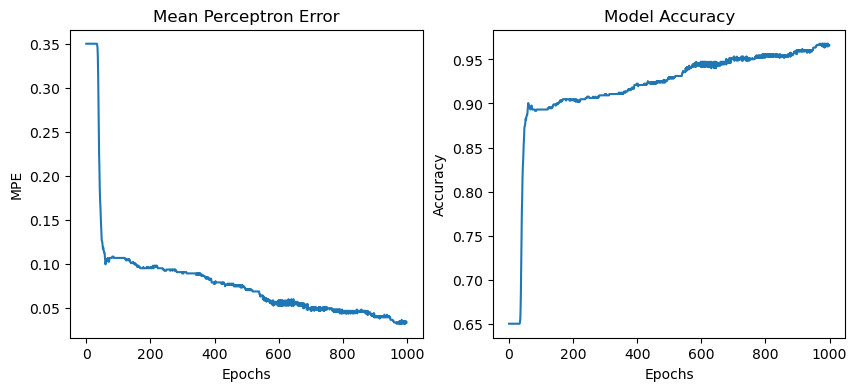

In [424]:
# 6
# Visualize the progress of your perceptron algorithm by plotting MPE and model 
# accuracy per epoch

# x range
num_epochs = np.arange(0, 1000, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# # plot MPE
ax1.plot(num_epochs, mpe_list)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MPE')
ax1.set_title('Mean Perceptron Error')

# plot accuracy
ax2.plot(num_epochs, acc_list)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy')

# display the plot
plt.show()

In [425]:
# 7
def list_contains(subset_list, all_feat_list):
    """
    helper thatchecks to see what elements in a master 
    list are contained in a given list
    :param subset_list: (list) a subset of features
    :param all_feat_list: (list) list of all the features
    :return: a list of 1 and 0 to indicate if element
    is present
    """
    list_contains = []
    for i in all_feat_list:
        if i in subset_list:
            list_contains.append(1)
        else: 
            list_contains.append(0)
    return list_contains


def create_subset_models(data): 
    """
    creates every possible subset of features from
    a dataframe
    :param data: (dataframe) dataframe
    :return: a list of subsets where each
    subset is a list of features (column names)
    """
    # sample size
    # samp_size = 50
    
    # all attribute columns from df (except first and last column)
    # first = bias term, last = outcome
    all_feat_list = list(data.columns[1:-1])
    
    # start with empty list
    subset_feat_list = []
    
    # for every feature: 
    for i in range(1, len(all_feat_list) + 1):
        
        # generate a list of list of combination of i 
        # values as a subset
        for subset in list(combinations(all_feat_list, i)):
            
            # add bias term and outcome
            subset = ['bias_term'] + list(subset) + ['outcome']
            subset_feat_list.append(subset)
            
    # take a sample from the list
    # subset_feat_list = sample(subset_feat_list, samp_size)
           
    # empty list to convert subset of strings into 0 and 1
    contains_feat = []
    for sublist in subset_feat_list:
        contains_feat.append(list_contains(sublist, all_feat_list))
        
    return contains_feat, subset_feat_list


def list_metrics(data, subset_feat_ls): 
    """
    using the metrics function, find the 5 
    scores for each row of data and append onto 
    each subset in list
    :param data: (dataframe) dataframe
    :param subset_feat_ls: (list) list of subset feature lists
    :return: a list of subsets where each
    subset now has 5 scores
    """
    list_of_lists_of_metrics = []
    # for each subset df in list of subsets
    for subset in subset_feat_list:
        
        # make subset into df
        sub_df = data[subset]
        
        # weight vector
        w = perceptron(sub_df, 0.0001, 1000)[0]
        
        # ypred values
        ypred = predict(sub_df.iloc[:, :-1], w).values.tolist()
        
        # y actual values
        y = data.iloc[:, -1].values
        
        # metrics on this sub dataframe
        accuracy, sensitivity, specificity, precision, f1_score = metrics(y, ypred)
        list_of_lists_of_metrics.append([accuracy, sensitivity, specificity, precision, f1_score])

    return list_of_lists_of_metrics
 
    
def append_feat_metrics(feat_list, metric_list):
    """
    take feature and metric lists and append them together 
    into 1 list
    :param feat_list: (list) list of list of ints indicated if
    feature is used
    :param metric_list: (list) list of list of metrics 
    corresponding to feat_list
    :return: a list
    """
    feat_metrics_list = []
    for i in range(len(feat_list)):
        feat_metrics_list.append(feat_list[i] + metric_list[i])
    return feat_metrics_list

In [430]:
# 7 - testing
contains_feat, subset_feat_list = create_subset_models(df)

list_of_lists_of_metrics = list_metrics(df, subset_feat_list)

metrics_df_rows = make_metrics_df(contains_feat, list_of_lists_of_metrics)

# metrics_df_rows

In [427]:
# 7
# Create the pandas DataFrame
new_df = pd.DataFrame(metrics_df_rows,
                      columns = ['thickness', 'size_uniformity', 'shape_uniformity', 
                                 'marg_adh','epithelial_size', 'bare_nuclei', 'bland_chromatin', 
                                 'norm_nucleoli', 'mitosis', 'accuracy', 'sensitivity', 
                                 'specificity', 'precision', 'f1_score'])

new_df = new_df.sort_values(by=['sensitivity', 'specificity'], ascending=[False, False])
new_df.head(20)

,thickness,size_uniformity,shape_uniformity,marg_adh,epithelial_size,bare_nuclei,bland_chromatin,norm_nucleoli,mitosis,accuracy,sensitivity,specificity,precision,f1_score
44,0,0,0,0,0,0,0,1,1,0.787701,0.986486,0.418410,0.759099,0.857982
319,1,0,0,1,0,0,1,1,1,0.950220,0.984234,0.887029,0.941810,0.962555
492,1,0,0,1,1,1,1,1,1,0.972182,0.981982,0.953975,0.975391,0.978676
432,1,0,0,1,1,1,1,0,1,0.970717,0.981982,0.949791,0.973214,0.977578
308,1,0,1,0,0,1,0,1,1,0.969253,0.981982,0.945607,0.971047,0.976484
401,1,1,0,1,1,1,1,0,0,0.964861,0.981982,0.933054,0.964602,0.973214
423,1,0,1,1,0,1,1,0,1,0.964861,0.981982,0.933054,0.964602,0.973214
436,1,0,0,0,1,1,1,1,1,0.964861,0.981982,0.933054,0.964602,0.973214
508,1,0,1,1,1,1,1,1,1,0.964861,0.981982,0.933054,0.964602,0.973214
48,1,1,0,0,0,1,0,0,0,0.961933,0.981982,0.924686,0.960352,0.971047


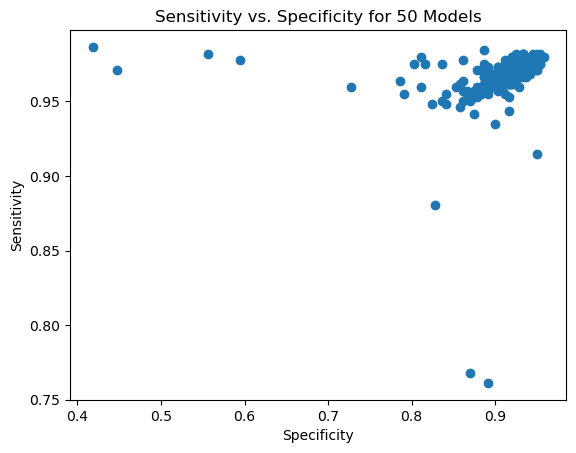

In [428]:
# 8
# plot specificity (x-axis) vs. sensitivity (y-axis) for each model

fig, ax = plt.subplots()
ax.scatter(new_df['specificity'], new_df['sensitivity'])
ax.set_xlabel('Specificity')
ax.set_ylabel('Sensitivity')
ax.set_title('Sensitivity vs. Specificity for 50 Models')

plt.show()

# 8 - analysis

In the context of identifying malignant breast cancer tumors, specificity, sensitivity,
precision, accuracy, and the F1 score are all very important. But overall, having a
high sensitivity may be most crucial. Maligmant tumors are life threatening, so high 
sensitivity measures how well the model can correctly identify all of the malignant tumors, 
which is critical for early detection and treatment. Having a high specificity to balance
sensitivity will also be important in making sure the model can identify all the benign tumors
to minimize unnecessary costs and scares for treatment and biopsies.

To take into consideration all five scores having a score >90%, the model with the
highested sensitivity uses the features:
- {thickness, shape_uniformity, bare_nuclei, norm_nucleoli, mitosis}
- with accuracy 0.969253, sensitvity 0.981982, specificity 0.945607, 
  precision 0.971047, and f1 score 0.976484. (when last ran)

If users wanted a model that had sensitivity and specificity values more
similar to each other, the model would use these features:
- {thickness, size_uniformity, shape_uniformity, bare_nuclei, norm_nucleoli}
- with accuracy 0.970717, sensitivity 0.979730, specificity 0.953975, 
  precision 0.975336, and f1 score 0.977528. (when last ran)

It is also important to note that both models use thickness, shape_uniformity, bare_nuclei, 
and norm_nucleoli, so this may lead to the conclusion that these are the  most important
features to consider when identifying a malignant tumor regardless of the model variation.
"""
